In [1]:
%run ./resources/library.py

In [2]:
style_notebook()

Digital Case Study: Multidrug-Resistant Tuberculosis (MDR-TB) Outbreak - Revisiting the 2005 Outbreak Investigation in Thailand by John Oeltmann

# Notebook 7, Part 3: Social Network Analysis

## Set up environment, load data

In [3]:
import pandas as pd

pd.__version__

'0.25.3'

In [4]:
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('max_colwidth', -1)  
pd.set_option('display.width', 1000)

Let's load the two batches of data for nodes and edges.

In [5]:
nodes_df5 = pd.read_pickle('outputs/nodes_df5.pickle') # nodes / cases (MDR-TB only)
edges_df6 = pd.read_pickle('outputs/edges_df6.pickle') # edges / links

In [6]:
nodes_df5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13 entries, 0 to 12
Data columns (total 9 columns):
CaseNo          13 non-null object
links           13 non-null int64
FAKEMIRUVNTR    13 non-null object
FAKEMIRUID      13 non-null int64
DRTYPE          13 non-null object
LON             13 non-null float64
LAT             13 non-null float64
COORDS          13 non-null object
SYMBOL          13 non-null object
dtypes: float64(2), int64(2), object(5)
memory usage: 1.0+ KB


In [7]:
nodes_df5.head()

,CaseNo,links,FAKEMIRUVNTR,FAKEMIRUID,DRTYPE,LON,LAT,COORDS,SYMBOL
0,TH-101783,1,012345678901234567890123,1,MDR-TB,100.828634,14.696434,"14.696434,100.828634",Red Triangle
1,TH-101823,4,012345678901234567890123,1,MDR-TB,100.828917,14.699857,"14.699857,100.828917",Red Triangle
2,TH-101579,4,012345678901234567890123,1,MDR-TB,100.828440,14.702731,"14.702731,100.82844",Red Triangle
3,TH-103009,1,012345678901234567890123,1,MDR-TB,100.831095,14.699261,"14.699261,100.831095",Red Triangle
4,TH-102909,1,012345678901234567890123,1,MDR-TB,100.830151,14.698980,"14.69898,100.830151",Red Triangle


## Using `bokeh` and `networkx` for Network Visualization

From Wikipedia, on [bokeh](https://en.wikipedia.org/wiki/Bokeh): 
> In photography, bokeh (/ˈboʊkeɪ/ BOH-kay; Japanese: [boke]) is the aesthetic quality of the blur produced in the out-of-focus parts of an image produced by a lens. Bokeh has been defined as "the way the lens renders out-of-focus points of light".

From the Python bokeh [website](https://bokeh.pydata.org/en/latest/):
> Bokeh is an interactive visualization library that targets modern web browsers for presentation. Its goal is to provide elegant, concise construction of versatile graphics, and to extend this capability with high-performance interactivity over very large or streaming datasets. Bokeh can help anyone who would like to quickly and easily create interactive plots, dashboards, and data applications.

On [NetworkX](https://networkx.github.io/):
> NetworkX is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

## Graphs, nodes and edges

A graph is made of nodes and edges. 

Let's set these up using our loaded dataframes.

In [8]:
nodes = list(nodes_df5['CaseNo'])

nodes

['TH-101783',
 'TH-101823',
 'TH-101579',
 'TH-103009',
 'TH-102909',
 'TH-103347',
 'TH-103927',
 'TH-102445',
 'TH-102460',
 'TH-104039',
 'TH-103773',
 'TH-102637',
 'TH-104090']

In [9]:
edges = [ tuple(x) for x in edges_df6[['CaseNo1', 'CaseNo2']].values ]

edges

[('TH-101783', 'TH-101823'),
 ('TH-101579', 'TH-101823'),
 ('TH-101823', 'TH-102445'),
 ('TH-101823', 'TH-102460'),
 ('TH-101579', 'TH-103927'),
 ('TH-101579', 'TH-104039'),
 ('TH-101579', 'TH-102637'),
 ('TH-103009', 'TH-103347'),
 ('TH-102909', 'TH-103347'),
 ('TH-103347', 'TH-103773'),
 ('TH-103927', 'TH-104090')]

Let's set up the attributes for our node interactive pop-ups.

In [10]:
attributes = {}
for each in nodes_df5.iterrows():
    new_dict = {each[1]['CaseNo']: {'CaseNo': each[1]['CaseNo'],\
                              'DrugResType': each[1]['DRTYPE'],\
                              'Links': each[1]['links']}}
    attributes.update(new_dict)

attributes

{'TH-101783': {'CaseNo': 'TH-101783', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-101823': {'CaseNo': 'TH-101823', 'DrugResType': 'MDR-TB', 'Links': 4},
 'TH-101579': {'CaseNo': 'TH-101579', 'DrugResType': 'MDR-TB', 'Links': 4},
 'TH-103009': {'CaseNo': 'TH-103009', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-102909': {'CaseNo': 'TH-102909', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-103347': {'CaseNo': 'TH-103347', 'DrugResType': 'MDR-TB', 'Links': 3},
 'TH-103927': {'CaseNo': 'TH-103927', 'DrugResType': 'MDR-TB', 'Links': 2},
 'TH-102445': {'CaseNo': 'TH-102445', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-102460': {'CaseNo': 'TH-102460', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-104039': {'CaseNo': 'TH-104039', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-103773': {'CaseNo': 'TH-103773', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-102637': {'CaseNo': 'TH-102637', 'DrugResType': 'MDR-TB', 'Links': 1},
 'TH-104090': {'CaseNo': 'TH-104090', 'DrugResType': 'MDR-TB', 'Links': 1}}

... and the tooltips where these will appear.

In [11]:
tooltips = [
    ("Case No:", "@CaseNo"),
    ("Drug Res Type:", "@DrugResType"),
    ("Links:", "@Links")
]

Let's run our `bokeh` and `networkx` Python code.

In [12]:
import networkx as nx

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, \
    Circle, HoverTool, TapTool, BoxSelectTool, \
    ColumnDataSource, LabelSet
from bokeh.models.graphs import from_networkx, \
    NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4
from bokeh.layouts import row

In [13]:
output_notebook()

Loading BokehJS ...

## Visualizing networks

### Setting up `G` as a `networkx` graph and adding nodes and edges

In [14]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

nx.set_node_attributes(G, attributes)

### Visualizing using NetworkX (quick check)

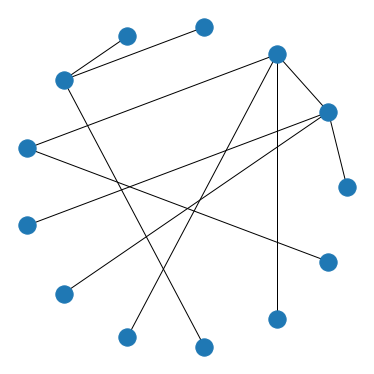

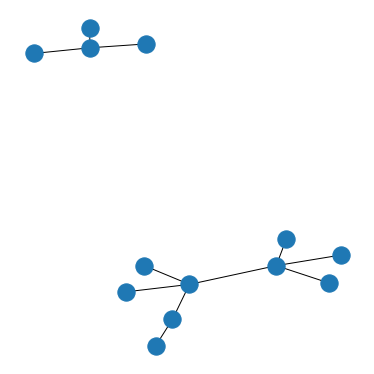

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

pos1 = nx.circular_layout(G)
pos2 = nx.spring_layout(G)

plt.figure(1, figsize=(5,5))
plt.title='Test'
nx.draw(G, pos1)

plt.figure(2, figsize=(5,5))
nx.draw(G,pos2) 

plt.show()


### Interactive visualization using Bokeh

#### Spring layout

In [16]:
# spring layout

plot1 = Plot(plot_width=450, plot_height=450,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot1.title.text = "MDR-TB Links - Spring Layout"
plot1.add_tools(HoverTool(tooltips=tooltips), TapTool(), BoxSelectTool())

graph_renderer1 = from_networkx(G, nx.spring_layout, scale=1, center=(0,0))
graph_renderer1.node_renderer.glyph = \
    Circle(size=20, fill_color=Spectral4[0])
graph_renderer1.node_renderer.selection_glyph = \
    Circle(size=20, fill_color=Spectral4[2])
graph_renderer1.node_renderer.hover_glyph = \
    Circle(size=20, fill_color=Spectral4[1])
graph_renderer1.edge_renderer.glyph = \
    MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=2)
graph_renderer1.edge_renderer.selection_glyph = \
    MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer1.edge_renderer.hover_glyph = \
    MultiLine(line_color=Spectral4[1], line_width=5)
graph_renderer1.selection_policy = NodesAndLinkedEdges()
graph_renderer1.inspection_policy = NodesAndLinkedEdges()

plot1.renderers.append(graph_renderer1)

#### Circular layout

In [17]:
# circular layout

plot2 = Plot(plot_width=450, plot_height=450,
            x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot2.title.text = "MDR-TB Links - Circular Layout"
plot2.add_tools(HoverTool(tooltips=tooltips), TapTool(), BoxSelectTool())

graph_renderer2 = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))
graph_renderer2.node_renderer.glyph = \
    Circle(size=20, fill_color=Spectral4[0])
graph_renderer2.node_renderer.selection_glyph = \
    Circle(size=20, fill_color=Spectral4[2])
graph_renderer2.node_renderer.hover_glyph = \
    Circle(size=20, fill_color=Spectral4[1])
graph_renderer2.edge_renderer.glyph = \
    MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=2)
graph_renderer2.edge_renderer.selection_glyph = \
    MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer2.edge_renderer.hover_glyph = \
    MultiLine(line_color=Spectral4[1], line_width=5)
graph_renderer2.selection_policy = NodesAndLinkedEdges()
graph_renderer2.inspection_policy = NodesAndLinkedEdges()

plot2.renderers.append(graph_renderer2)

#### Showing spring and circular layouts side by  side

In [18]:
show(row(plot1, plot2))

### Underlying data

In [19]:
graph_renderer1.node_renderer.data_source.data

{'CaseNo': ['TH-101783',
  'TH-101823',
  'TH-101579',
  'TH-103009',
  'TH-102909',
  'TH-103347',
  'TH-103927',
  'TH-102445',
  'TH-102460',
  'TH-104039',
  'TH-103773',
  'TH-102637',
  'TH-104090'],
 'DrugResType': ['MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB',
  'MDR-TB'],
 'Links': [1, 4, 4, 1, 1, 3, 2, 1, 1, 1, 1, 1, 1],
 'index': ['TH-101783',
  'TH-101823',
  'TH-101579',
  'TH-103009',
  'TH-102909',
  'TH-103347',
  'TH-103927',
  'TH-102445',
  'TH-102460',
  'TH-104039',
  'TH-103773',
  'TH-102637',
  'TH-104090']}

### Graph information

In [20]:
G.number_of_nodes()

13

In [21]:
G.number_of_edges()

11

## Case Study Questions

1. What information can you glean from the two network displays?

Type answer here.

## References

1. Kapoor A. Social Network Analysis in Python. URL: https://www.datacamp.com/community/tutorials/social-network-analysis-python (last accessed 7/21/2019)